In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Loader

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/Shadow_Removal/models')
from dataloader import Shadow_Removal

#Parameter for iterations!
batch_size = 32 #mini-batch size
#train = Shadow_Removal(train_data=True)
test = Shadow_Removal(train_data=False)

#trainloader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = 0)
testloader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True, num_workers = 0)

Shadow Detector

In [3]:
# Shadow Detection Reload
os.chdir('/content/drive/My Drive/Colab Notebooks/Shadow_Removal/models')
from Shadow_Detection import conv_deconv
SD = conv_deconv()
os.chdir('/content/drive/My Drive/Colab Notebooks/Shadow_Removal')
check=os.listdir("shadow_detection") #checking if checkpoints exist to resume training
import re
if len(check):
    check.sort(key=lambda x:int((x.split('_')[2]).split('.')[0]))
    SD = torch.load("shadow_detection/"+check[-1])
if torch.cuda.is_available(): #use gpu if available
	SD.cuda()   

Shadow Remove

In [4]:
# Shadow Remove Reload
os.chdir('/content/drive/My Drive/Colab Notebooks/Shadow_Removal/models')
from Shadow_Remove import Conv_deconv

SR = Conv_deconv()
os.chdir('/content/drive/My Drive/Colab Notebooks/Shadow_Removal')
check=os.listdir("shadow_remove") #checking if checkpoints exist to resume training
import re
if len(check):
    check.sort(key=lambda x:int((x.split('_')[2]).split('.')[0]))
    SR = torch.load("shadow_remove/"+check[-1])
if torch.cuda.is_available(): #use gpu if available
	SR.cuda()   

View Result

Train Data

In [ ]:
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable

def imshow(img):
    img = img * 128 + 127 
    img = img.long()
    img = torch.where(img > 255, 255, img)
    img = torch.where(img < 0, 0, img)
    img = img.int()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#del iter
# get some random training images
dataiter1 = iter(trainloader)
images, labels = dataiter1.next()
print(images.size())
# show images
images = torch.narrow(images, 1, 0, 3)
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(labels))
shadow = SD(Variable(images.type(torch.FloatTensor).cuda())).cpu()
shadow = torch.where(shadow > 0.9, 1, 0)
images = torch.cat([images, shadow], dim=1)
predict = model(Variable(images.type(torch.FloatTensor).cuda())).cpu()
imshow(torchvision.utils.make_grid(predict))

Test Data

torch.Size([32, 4, 120, 160])


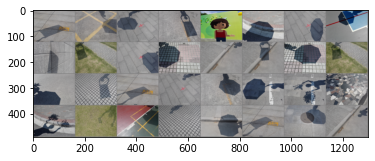

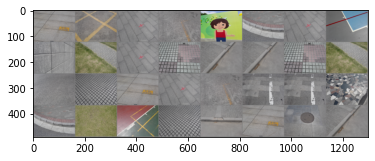

RuntimeError: ignored

In [6]:
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable

def imshow(img):
    img = img * 128 + 127 
    img = img.long()
    img = torch.where(img > 255, 255, img)
    img = torch.where(img < 0, 0, img)
    img = img.int()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter1 = iter(testloader)
images, labels = dataiter1.next()
print(images.size())
# show images
images = torch.narrow(images, 1, 0, 3)
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(labels))
shadow = SD(Variable(images.type(torch.FloatTensor).cuda())).cpu()
shadow = torch.where(shadow > 0.9, 1, 0)
images = torch.cat([images, shadow], dim=1)
predict = SR(Variable(images.type(torch.FloatTensor).cuda())).cpu()
imshow(torchvision.utils.make_grid(predict))

Compute PSNR

In [ ]:
def unormalize(img):
    img = img * 128 + 127 
    img = img.long()
    img = torch.where(img > 255, 255, img)
    img = torch.where(img < 0, 0, img)
    img = img.int()
    img = img.float()
    return img


testloader = torch.utils.data.DataLoader(test, batch_size = 32, shuffle = True, num_workers = 0)
n_iters = int(len(test)/batch_size)
mse = 0
for i in range(n_iters):
  dataiter = iter(testloader)
  img1, img2 = dataiter.next()
  img1 = torch.narrow(img1, 1, 0, 3)
  shadow = SD(Variable(img1.type(torch.FloatTensor).cuda())).cpu()
  shadow = torch.where(shadow > 0.9, 1, 0)
  img1 = torch.cat([img1, shadow], dim=1)
  img1 = model(Variable(img1.type(torch.FloatTensor).cuda())).cpu()
  img1 = unormalize(img1)
  img2 = unormalize(img2)
  mse += criterion(img1, img2)

mse = mse/n_iters
print(20 * torch.log10(255.0 / torch.sqrt(mse)))